# Mongochess bot notebook


#### Setup


In [1]:
import chess
import chess.engine
import random
import numpy


def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(0, max_depth)

    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break

    return board


def stockfish_eval(board, depth):
    with chess.engine.SimpleEngine.popen_uci("/opt/homebrew/bin/stockfish") as engine:
        info = engine.analyse(board, chess.engine.Limit(depth=depth))
        score = info["score"].white().score()
        return score

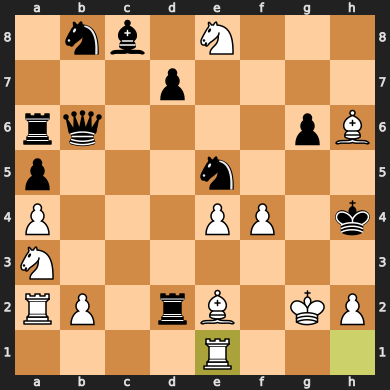

In [2]:
rnd_board = random_board()
rnd_board

In [3]:
print(stockfish_eval(rnd_board, 10))

-7


In [4]:
squares_index = {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7}

def square_to_index(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board):
    board3d = numpy.zeros((14, 8, 8), dtype=numpy.uint8)

    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1

        for square in board.pieces(piece, chess.BLACK):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1
    
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.from_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.from_square)
        board3d[13][i][j] = 1
    board.turn = aux

    return board3d

In [5]:
split_dims(rnd_board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [6]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return models.Model(inputs=board3d, outputs=x)


In [7]:
model = build_model(32, 4)

In [ ]:
%%script false
import numpy as np
from tqdm.notebook import tqdm

def create_data_row():
    board = random_board(max_depth)
    y_val = stockfish_eval(board, 10)
    if isinstance(y_val, int):
        x_val = split_dims(board)
        return (x_val, y_val)
    return create_data_row()

def generate_dataset(num_samples, max_depth):
    X, y = [], []
    for _ in tqdm(range(num_samples)):
        x_val, y_val = create_data_row()
        X.append(x_val)
        y.append(y_val)
    return np.array(X), np.array(y)

X, y = generate_dataset(1500000, 200)
np.savez("dataset.npz", X, y)

In [11]:
def get_dataset():
    container = numpy.load("data/dataset.npz", allow_pickle=True)
    b, v = container["arr_0"], container["arr_1"]
    return b, v

x_train, y_train = get_dataset()

print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [12]:
from tqdm.notebook import tqdm

indexes_with_none = []
for index, num in enumerate(y_train):
    if not isinstance(num, int):
        indexes_with_none.append(index)

print("Entries with incorrect indexes", len(indexes_with_none))
#x_train = numpy.delete(x_train, indexes_with_none)
y_train = numpy.delete(y_train, indexes_with_none)

new_x_train_array = []
for index, value in enumerate(tqdm(x_train)):
    if index not in indexes_with_none:
        new_x_train_array.append(value)

print(numpy.array(new_x_train_array).shape)

print(y_train.shape)

Entries with incorrect indexes 160441


  0%|          | 0/1500000 [00:00<?, ?it/s]

(1339559, 14, 8, 8)
(1500000, 14, 8, 8)
(1339559,)


In [18]:
model.compile(optimizer=optimizers.legacy.Adam(5e-4), loss="mean_squared_error")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [26]:
import tensorflow.keras.callbacks as callbacks

model.fit(numpy.array(new_x_train_array), y_train.astype("float32"),
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor="loss", patience=10),
                     callbacks.EarlyStopping(monitor="loss", patience=15, min_delta=0.001)])


Epoch 1/1000
589/589 [==============================] - 75s 128ms/step - loss: 828618.4375 - val_loss: 819302.6875 - lr: 5.0000e-04
Epoch 2/1000
589/589 [==============================] - 74s 125ms/step - loss: 828614.6875 - val_loss: 819304.5000 - lr: 5.0000e-04
Epoch 3/1000
589/589 [==============================] - 74s 126ms/step - loss: 828613.7500 - val_loss: 819304.0625 - lr: 5.0000e-04
Epoch 4/1000
589/589 [==============================] - 75s 128ms/step - loss: 828613.6250 - val_loss: 819298.9375 - lr: 5.0000e-04
Epoch 5/1000
589/589 [==============================] - 75s 128ms/step - loss: 828614.1250 - val_loss: 819297.7500 - lr: 5.0000e-04
Epoch 6/1000
589/589 [==============================] - 1013s 2s/step - loss: 828612.3125 - val_loss: 819300.8125 - lr: 5.0000e-04
Epoch 7/1000
589/589 [==============================] - 661s 1s/step - loss: 828612.0000 - val_loss: 819298.6250 - lr: 5.0000e-04
Epoch 8/1000
589/589 [==============================] - 2137s 4s/step - loss: 8

In [28]:
model.save("model_v1.keras")

In [29]:
def minmax_eval(board):
    board3d = split_dims(board)
    board3d = numpy.expand_dims(board3d, 0)
    return model.predict(board3d)[0][0]

def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minmax_eval(board)

    if maximizing_player:
        max_eval = -numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break;
        return max_eval
    else:
        min_eval = numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            alpha = min(beta, eval)
            if beta <= alpha:
                break;
        return min_eval

def get_ai_move(board, depth):
    max_move = None
    max_eval = -numpy.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth -1, -numpy.inf, numpy.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            max_move = move
    return max_move
            

1/1 [==============================] - 0s 10ms/step


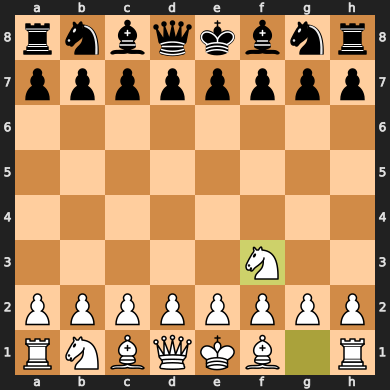

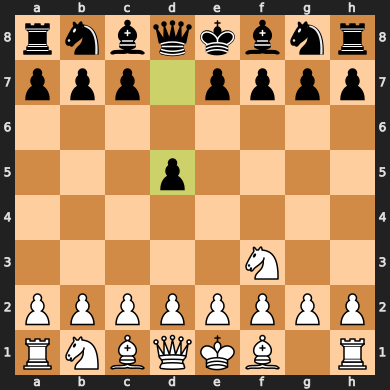

1/1 [==============================] - 0s 9ms/step


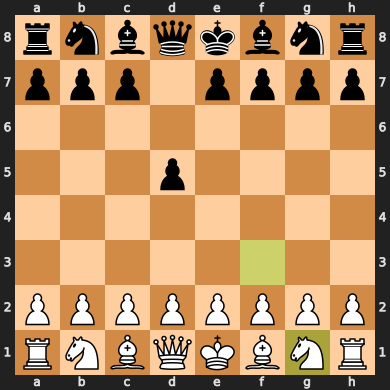

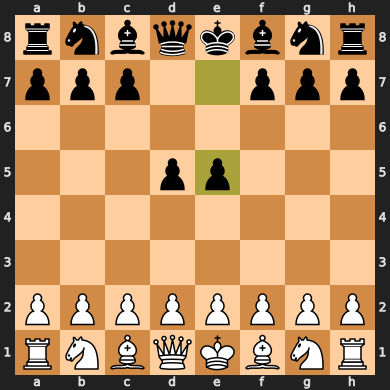

1/1 [==============================] - 0s 8ms/step


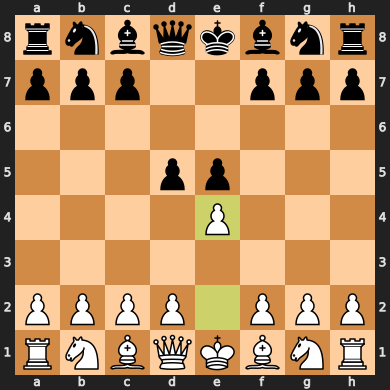

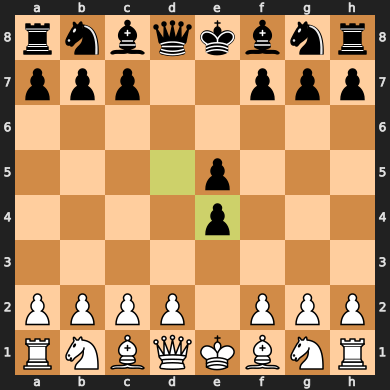

1/1 [==============================] - 0s 8ms/step


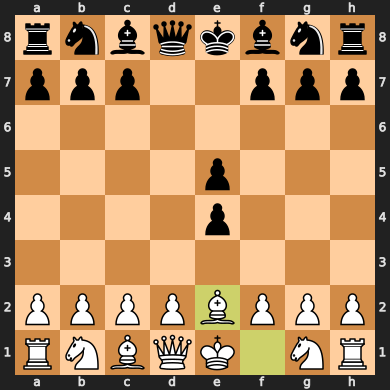

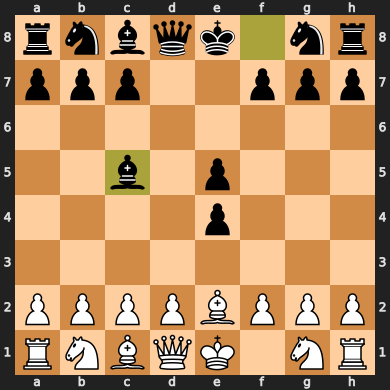

1/1 [==============================] - 0s 8ms/step


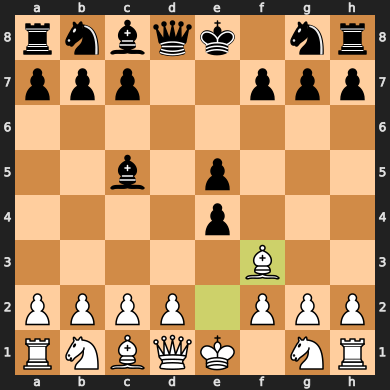

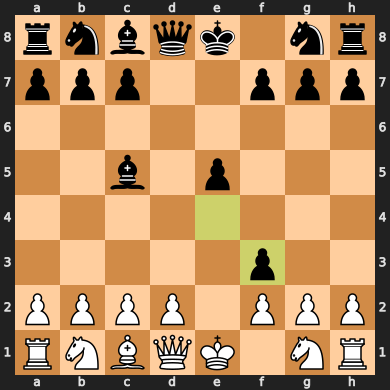

1/1 [==============================] - 0s 7ms/step


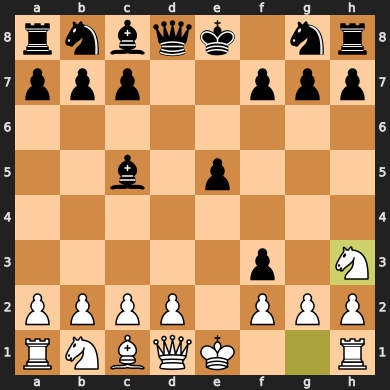

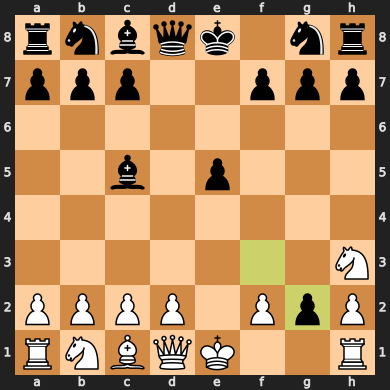

1/1 [==============================] - 0s 7ms/step


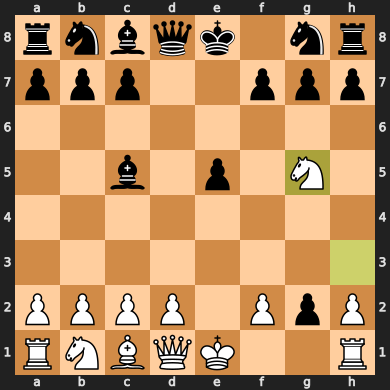

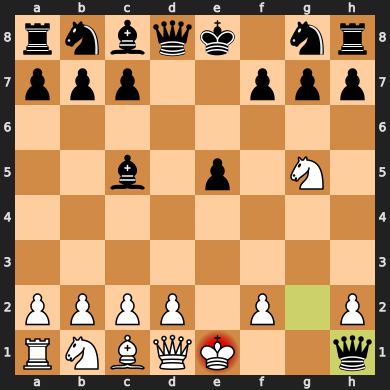

1/1 [==============================] - 0s 8ms/step


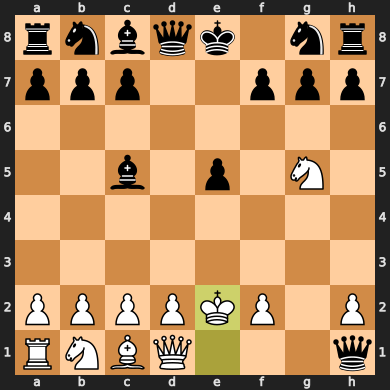

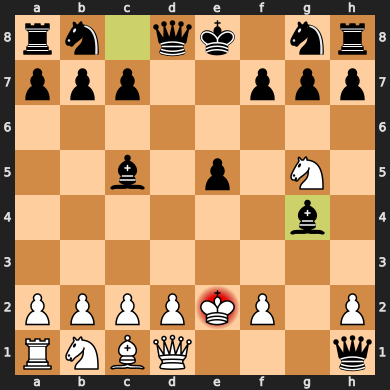

1/1 [==============================] - 0s 7ms/step


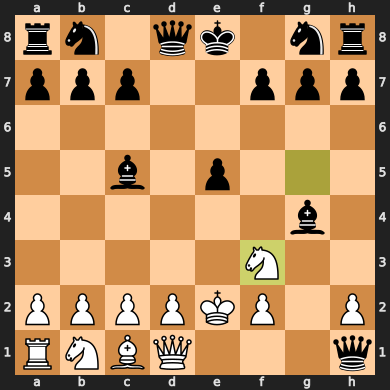

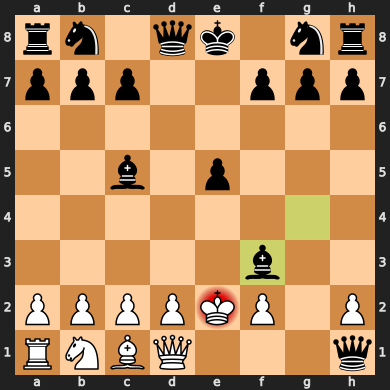

In [36]:
board = chess.Board()
with chess.engine.SimpleEngine.popen_uci("/opt/homebrew/bin/stockfish") as engine:
    while True:
        move = get_ai_move(board, 1)
        board.push(move)
        display(board)
        if board.is_game_over():
            break

        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_ALL)["pv"][0]
        board.push(move)
        display(board)
        if board.is_game_over():
            break